In [2]:
import glob
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
import sys


import caiman as cm

import cv2
import logging
import argparse
import tifffile as tif

In [12]:
# movie chunks to be processed
vid_dir = '/gpfs/data/shohamlab/shared_data/jon_2p_data/JG1150/190708/aligned'
os.chdir(vid_dir)
vid_list = sorted(glob.glob('*.tif'))
print(vid_list)

['JG1150_190708_field2_stim_00001_00001_aligned.tif', 'JG1150_190708_field2_stim_00001_00003_aligned.tif', 'JG1150_190708_field2_stim_00001_00004_aligned.tif', 'JG1150_190708_field2_stim_00001_00005_aligned.tif', 'JG1150_190708_field2_stim_00002_00001_aligned.tif', 'JG1150_190708_field2_stim_00002_00002_aligned.tif', 'JG1150_190708_field2_stim_00002_00003_aligned.tif', 'JG1150_190708_field2_stim_00002_00004_aligned.tif', 'JG1150_190708_field2_stim_00002_00005_aligned.tif', 'JG1150_190708_field2_stim_00003_00001_aligned.tif', 'JG1150_190708_field2_stim_00003_00002_aligned.tif', 'JG1150_190708_field2_stim_00003_00003_aligned.tif', 'JG1150_190708_field2_stim_00003_00005_aligned.tif', 'JG1150_190708_field2_stim_00004_00001_aligned.tif', 'JG1150_190708_field2_stim_00004_00002_aligned.tif', 'JG1150_190708_field2_stim_00004_00003_aligned.tif', 'JG1150_190708_field2_stim_00004_00005_aligned.tif', 'JG1150_190708_field2_stim_00005_00002_aligned.tif', 'JG1150_190708_field2_stim_00005_00003_aligne

In [13]:
n = 0
f = vid_list[n]
print('using video file: {}'.format(f))

using video file: JG1150_190708_field2_stim_00001_00001_aligned.tif


In [14]:
# channels from scanimage (to be de-interleaved)
n_channels = 1

# which channels to save (suffix will indicate channel) (0-indexed)
saved_channels = [0]

# filter out bad frames with a small fraction of extreme values
# the test statistic is LOW for stim frames
# set stim_percentile to be a slight overestimate of the percentage of stim frames in the video
filter_frames = True
stim_percentile = 7

# use an AR filter to smooth out the movie
# alpha is the smoothing parameter (i.e. alpha=1 means a flat moving average of size nSmooth, while alpha=0 means no smoothing)
# use alpha=0 to disable
alpha=0
nSmooth = 1
smoothWindow = np.flip(np.array([alpha**x for x in range(nSmooth)])) + 1e-6
smoothWindow = smoothWindow / smoothWindow.sum()

In [67]:
n=0
mov = tif.imread(f)
if len(mov.shape)==3:
    mov = np.expand_dims(mov,axis=1).astype('float32')
for ch_num in saved_channels:
    print('Processing channel {}'.format(ch_num), flush=True)
ch_out_base, ch_out_file = os.path.split(f)
pre_ext, ext = os.path.splitext(ch_out_file)

if filter_frames:
    filter_tag = '_filtered'
else:
    filter_tag = ''
ch_out_file = os.path.join(ch_out_base , pre_ext) + filter_tag + '_channel_{}'.format(ch_num) + '.tif'
ch_mov = mov[ch_num::n_channels]

if filter_frames:
    ch_mean = np.mean(ch_mov)
    ch_means = np.mean(ch_mov,axis=(-1,-2), keepdims=True)

frameshape = ch_mov.shape[-2:]
totpix = frameshape[0]*frameshape[1]

Processing channel 0


In [68]:
ch_mov_diff = np.diff(ch_mov,axis=0)

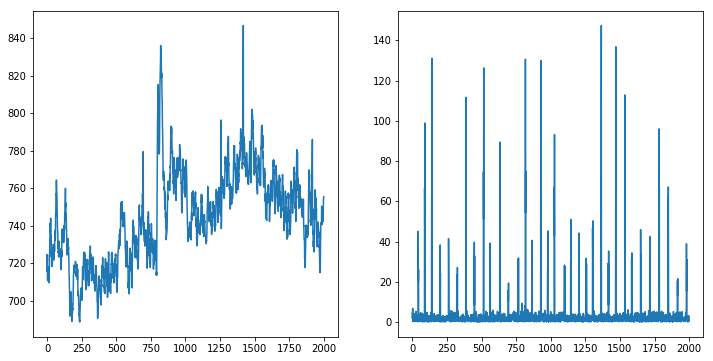

In [59]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(ch_mov.mean(axis=(-1,-2)))
plt.subplot(1,2,2)
plt.plot(np.abs(ch_mov_diff.mean(axis=(-1,-2))))
plt.show()

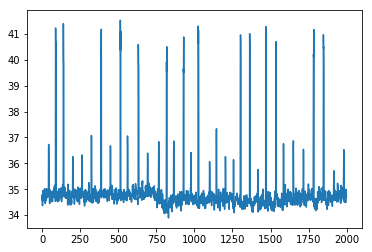

In [34]:
# try simple test statistic based on ch_mov_diff
#mystat = np.power(np.sum(np.power((ch_mov_diff - ch_mov_diff.mean(axis=(-2,-1), keepdims=True)),4),axis=(-1,-2)) / np.var(ch_mov_diff,axis=(-2,-1))**2, 1/4)
plt.plot(mystat)
plt.show()

In [61]:
np.abs(ch_mov_diff.mean(axis=(-1,-2,-3)))

(1999, 1)

In [33]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [74]:
good_inds = np.argwhere(~is_bad_ind)[:,0]
good_

array([   0,    1,    4, ..., 1995, 1996, 1997])

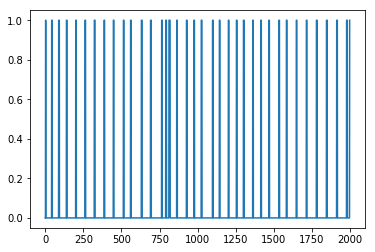

[   2    3   42   43   44   45   88   89   90   91   92  139  140  141
  142  200  201  202  203  261  262  263  264  322  323  324  325  326
  386  387  388  389  447  448  449  450  513  514  515  516  560  561
  562  563  631  632  633  634  635  691  692  693  694  695  764  765
  766  767  791  792  793  794  795  812  813  814  815  816  817  818
  819  863  864  865  866  927  928  929  930  976  977  978  979 1024
 1025 1026 1027 1028 1098 1099 1100 1101 1143 1144 1145 1146 1202 1203
 1204 1205 1255 1256 1257 1258 1301 1302 1303 1304 1305 1362 1363 1364
 1365 1415 1416 1417 1418 1468 1469 1470 1471 1534 1535 1536 1537 1583
 1584 1585 1586 1648 1649 1650 1651 1714 1715 1716 1717 1780 1781 1782
 1783 1784 1846 1847 1848 1849 1850 1913 1914 1915 1916 1917 1978 1979
 1980 1981 1982 1998]


In [69]:
is_bad_ind = is_outlier(np.abs(ch_mov_diff.mean(axis=(-1,-2,-3))))
is_bad_ind = np.concatenate([is_bad_ind[:-1] | is_bad_ind[1:],[True]])
bad_inds = np.argwhere(is_bad_ind).flatten()
good_inds = np.argwhere(~is_bad_ind).flatten()
plt.plot(is_bad_ind)
plt.show()
print(bad_inds)

In [ ]:
# get test statistic to measure extreme values: ratio of differences between percentiles
# will be LOW for stim frames, which have a small fraction of very high values
pcts = np.percentile(ch_mov_diff, (50, 75, 99.9),axis=(-1,-2))
mystat =  (pcts[1] - pcts[0]  ) / (pcts[2] - pcts[1])
mystat = np.nan_to_num(mystat) # nan values sent to 0
statthresh = np.percentile(mystat,stim_percentile) 
filter_cond = mystat > statthresh


good_inds = np.argwhere(filter_cond)[:,0]
bad_inds = np.argwhere(~filter_cond)[:,0]

if len(good_inds)==0:
    raise Exception('all frames have been filtered out from file {}'.format(f))

In [48]:
next_good_ind

inf

In [70]:
for bad_ind in bad_inds:
    try:
        prev_good_ind = good_inds[np.argwhere( good_inds < bad_ind)[-1,0]]
    except:
        prev_good_ind = -np.Inf
    try:
        next_good_ind = good_inds[np.argwhere( good_inds > bad_ind)[0,0]]
    except:
        next_good_ind = np.Inf
    if prev_good_ind < 0:
        ch_mov[bad_ind] = ch_mov[next_good_ind]
    elif next_good_ind > good_inds.max():
        ch_mov[bad_ind] = ch_mov[prev_good_ind]
    else:
        gapfrac = (bad_ind - prev_good_ind) / (next_good_ind - prev_good_ind)
        ch_mov[bad_ind] = ( 1 - gapfrac) * ch_mov[prev_good_ind] + gapfrac * ch_mov[next_good_ind]




print('Replaced {} bad frames from file {}, channel {}'.format( len(bad_inds), f, ch_num), flush=True)
print('')

Replaced 158 bad frames from file JG1150_190708_field2_stim_00001_00001_aligned.tif, channel 0



In [71]:
# perform smoothing
if alpha==0:
    smoothMov=ch_mov
else:
    smoothMov = np.zeros_like(ch_mov)
for n, mult in enumerate(smoothWindow):
    movFinalFrame = -(nSmooth-n-1) if nSmooth > n+1 else None
    smoothMov[(nSmooth-n-1):] = smoothMov[(nSmooth-n-1):] + mult * ch_mov[:movFinalFrame]
initSmoothComp = 1/np.cumsum(np.flip(smoothWindow))

print('{} {}'.format(smoothMov.shape, initSmoothComp.shape),flush=True)
smoothMov[:nSmooth] = smoothMov[:nSmooth] * initSmoothComp.reshape((-1,) + tuple(np.ones(len(smoothMov.shape)-1, dtype='int')))

(2000, 1, 512, 512) (1,)


In [72]:
if os.path.exists(ch_out_file):
    os.remove(ch_out_file)

print('Saving to file {}'.format(ch_out_file), flush=True)
tif.imsave(ch_out_file, data=smoothMov,  imagej=True)
print('Save complete.')
print('', flush=True)

print('Processing complete.', flush=True)
        

Saving to file JG1150_190708_field2_stim_00001_00001_aligned_filtered_channel_0.tif
Save complete.

Processing complete.


In [51]:
ch_out_file

'JG1150_190708_field2_stim_00001_00001_aligned_filtered_channel_0.tif'

0